# COGS 108 - Final Project (change this to your project's title)

## Permissions

Place an `X` in the appropriate bracket below to specify if you would like your group's project to be made available to the public. (Note that student names will be included (but PIDs will be scraped from any groups who include their PIDs).

* [  ] YES - make available
* [  ] NO - keep private

# Overview

*Fill in your overview here*

# Names

- Ant Man
- Hulk
- Iron Man
- Thor
- Wasp

<a id='research_question'></a>
# Research Question

*Fill in your research question here*

<a id='background'></a>

## Background & Prior Work

*Fill in your background and prior work here* 

References (include links):
- 1)
- 2)

# Hypothesis


*Fill in your hypotheses here*

# Dataset(s)

*Fill in your dataset information here*

(Copy this information for each dataset)
- Dataset Name:
- Link to the dataset:
- Number of observations:

1-2 sentences describing each dataset. 

If you plan to use multiple datasets, add 1-2 sentences about how you plan to combine these datasets.

# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
beer_data_set = pd.read_csv('beer_data_set.csv')
descriptors = pd.ExcelFile('Beer Descriptors Simplified.xlsx')
beer_descriptors = []#pd.read_excel('Beer Descriptors Simplified.xlsx')
for sheet in descriptors.sheet_names:
    df = descriptors.parse(sheet)
    beer_descriptors.append(df)
description_df = pd.concat(beer_descriptors, ignore_index=False, axis=1)

# Data Cleaning


Our data cleaning process:

We first looked at the columns and dropped unnecessary columns and renamed columns for simplicity. We then checked for missing values in the data set and dropped the rows that contained missing beer entries (there were not many missing values). There are 11 descriptors for each beer. To handle the many descriptors, we grouped each into one of three categores: 'flavor and aroma', 'mouthfeel', 'taste'. Many beer styles were the same but contained little difference, for example: 'IPA - Hazy' and 'IPA - Summer'. We grouped these similiar beer styles so tha we can better group the beers themselves, for example: grouping those IPAs into one overall IPA style. Finally, the descriptors for each bear had a score based on the number of descriptor words used for that beer. Since there were a different number of potential descriptor words for each, we standardized each score to be able to better compare the beers. 

In [3]:
# remove impact columns from the descriptions dataframe
description_df = description_df.drop(description_df.filter(regex='Impact').columns, axis=1)
# lowercase the column names
description_df.columns = description_df.columns.str.lower()
# rename columns to match the descriptors in both data sets
description_df = description_df.rename(columns = {'fruity':'fruits', 'astringent':'astringency', 'alcoholic':'alcohol'})
description_df

# lowercase the column names
beer_data_set.columns = beer_data_set.columns.str.lower()
# drop 'style key' column and rename 'name' column to 'beer'
beer_data_set = (beer_data_set.drop(columns = ['style key'])
        .rename(columns = {'name': 'beer'})
)
beer_data_set

# checking for missing values
beer_data_set.isna().sum()

# drop rows that contain missing beer entries
beer_data_set = beer_data_set[beer_data_set['beer'].notna()]
beer_data_set.head()

,beer,key,style,brewery,description,abv,ave rating,min ibu,max ibu,astringency,body,alcohol,bitter,sweet,sour,salty,fruits,hoppy,spices,malty
0,Amber,251,Altbier,Alaskan Brewing Co.,"Notes:Richly malty and long on the palate, wit...",5.3,3.65,25,50,13,32,9,47,74,33,0,33,57,8,111
1,Double Bag,252,Altbier,Long Trail Brewing Co.,"Notes:This malty, full-bodied double alt is al...",7.2,3.90,25,50,12,57,18,33,55,16,0,24,35,12,84
2,Long Trail Ale,253,Altbier,Long Trail Brewing Co.,Notes:Long Trail Ale is a full-bodied amber al...,5.0,3.58,25,50,14,37,6,42,43,11,0,10,54,4,62
3,Doppelsticke,254,Altbier,Uerige Obergärige Hausbrauerei,Notes:,8.5,4.15,25,50,13,55,31,47,101,18,1,49,40,16,119
4,Scurry,255,Altbier,Off Color Brewing,Notes:Just cause it's dark and German doesn't ...,5.3,3.67,25,50,21,69,10,63,120,14,0,19,36,15,218


In [4]:
# group the descriptors into three groups: 'flavor and aroma', 'mouthfeel', 'taste'
mouthfeel = ['astringency',	'body',	'alcohol']
taste = ['bitter', 'sweet', 'sour', 'salty']
flavor_and_aroma = ['fruits', 'hoppy', 'spices', 'malty']
beer_data_set['mouthfeel'] = beer_data_set[mouthfeel].sum(axis=1)
beer_data_set['taste'] = beer_data_set[taste].sum(axis=1)
beer_data_set['flavor_and_aroma'] = beer_data_set[flavor_and_aroma].sum(axis=1)
beer_data_set

# aggregated the style of beers into common groups. ex: IPA, Lager, etc.
beer_data_set['style'] = beer_data_set['style'].apply(lambda x: x.split('-')[0])
beer_data_set

# number of beers for each style
beer_data_set['style'].value_counts()

#check for duplicate beers
beer_data_set['beer'].value_counts()

# aggregate the data so that there is only one review for each beer
beer_data_set = beer_data_set.groupby(['style', 'beer']).mean().reset_index()
beer_data_set

,style,beer,key,abv,ave rating,min ibu,max ibu,astringency,body,alcohol,...,sweet,sour,salty,fruits,hoppy,spices,malty,mouthfeel,taste,flavor_and_aroma
0,Altbier,ALTerior Motive,297.0,6.3,4.05,25.0,50.0,27.0,61.0,11.0,...,61.0,46.0,0.0,40.0,77.0,14.0,110.0,99.0,163.0,241.0
1,Altbier,Ad Astra Ale,264.0,5.6,3.69,25.0,50.0,7.0,30.0,5.0,...,43.0,13.0,1.0,13.0,50.0,6.0,93.0,42.0,100.0,162.0
2,Altbier,Alt-eration Ale,271.0,5.0,3.81,25.0,50.0,21.0,43.0,3.0,...,54.0,7.0,0.0,10.0,60.0,9.0,111.0,67.0,115.0,190.0
3,Altbier,Altbier,262.0,4.7,4.00,25.0,50.0,34.0,48.0,9.0,...,59.0,25.0,1.0,32.0,68.0,12.0,121.0,91.0,140.0,233.0
4,Altbier,Alternate Dimension,300.0,5.6,3.66,25.0,50.0,25.0,50.0,12.0,...,61.0,20.0,0.0,21.0,59.0,26.0,139.0,87.0,153.0,245.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5346,Winter Warmer,Winter Warmer,673.5,7.2,3.50,35.0,50.0,7.5,50.5,28.5,...,58.0,15.5,0.5,25.0,25.5,79.0,85.0,86.5,110.5,214.5
5347,Winter Warmer,Winter Welcome AleSamuel Smith Old Brewery (Ta...,654.0,6.0,3.69,35.0,50.0,17.0,55.0,18.0,...,65.0,22.0,1.0,30.0,69.0,30.0,95.0,90.0,137.0,224.0
5348,Winter Warmer,Winterbraun,678.0,8.0,3.75,35.0,50.0,4.0,74.0,35.0,...,77.0,17.0,2.0,29.0,37.0,27.0,126.0,113.0,148.0,219.0
5349,Winter Warmer,Winterhook,661.0,6.0,3.62,35.0,50.0,11.0,47.0,23.0,...,51.0,15.0,0.0,15.0,93.0,40.0,97.0,81.0,133.0,245.0


In [5]:
# check if the values in the descriptors aren't greater than the amount of descriptive words
check_desc = beer_data_set.set_index('beer').iloc[:, 5:].reset_index()
for desc in description_df.columns:
    check_desc[desc] = description_df[desc].dropna().count() - check_desc[desc]

# we can see that there are some negative values in the descriptor fields. This implies that the same word was used more than once to describe the beer.
check_desc

# the number of impact words for each beer feature
num_desc_words = np.invert(description_df.isna()).sum()


mouthfeel = ['astringency',	'body',	'alcohol']
taste = ['bitter', 'sweet', 'sour', 'salty']
flavor_and_aroma = ['fruits', 'hoppy', 'spices', 'malty']
# the number of descriptors for each group
num_mouthfeel = np.invert(description_df[mouthfeel].isna()).sum().sum()
num_taste = np.invert(description_df[taste].isna()).sum().sum()
num_flavor = np.invert(description_df[flavor_and_aroma].isna()).sum().sum()

In [6]:
# standardize the descriptors and descriptor groups
beer_data_set['astringency'] = beer_data_set['astringency'].apply(lambda x: x  / num_desc_words.loc['astringency'])

beer_data_set['body'] = beer_data_set['body'].apply(lambda x: x  / num_desc_words.loc['body'])

beer_data_set['alcohol'] = beer_data_set['alcohol'].apply(lambda x: x  / num_desc_words.loc['alcohol'])

beer_data_set['bitter'] = beer_data_set['bitter'].apply(lambda x: x  / num_desc_words.loc['bitter'])

beer_data_set['sweet'] = beer_data_set['sweet'].apply(lambda x: x  / num_desc_words.loc['sweet'])

beer_data_set['sour'] = beer_data_set['sour'].apply(lambda x: x  / num_desc_words.loc['sour'])

beer_data_set['salty'] = beer_data_set['salty'].apply(lambda x: x  / num_desc_words.loc['salty'])

beer_data_set['fruits'] = beer_data_set['fruits'].apply(lambda x: x  / num_desc_words.loc['fruits'])

beer_data_set['hoppy'] = beer_data_set['hoppy'].apply(lambda x: x  / num_desc_words.loc['hoppy'])

beer_data_set['spices'] = beer_data_set['spices'].apply(lambda x: x  / num_desc_words.loc['spices'])

beer_data_set['malty'] = beer_data_set['malty'].apply(lambda x: x  / num_desc_words.loc['malty'])

beer_data_set['mouthfeel'] = beer_data_set['mouthfeel'].apply(lambda x: x  / num_mouthfeel)

beer_data_set['taste'] = beer_data_set['taste'].apply(lambda x: x  / num_taste)

beer_data_set['flavor_and_aroma'] = beer_data_set['flavor_and_aroma'].apply(lambda x: x  / num_taste)

In [7]:
# final clean data set
final = beer_data_set
final


,style,beer,key,abv,ave rating,min ibu,max ibu,astringency,body,alcohol,...,sweet,sour,salty,fruits,hoppy,spices,malty,mouthfeel,taste,flavor_and_aroma
0,Altbier,ALTerior Motive,297.0,6.3,4.05,25.0,50.0,0.303371,0.628866,0.171875,...,0.476562,0.414414,0.000000,0.229885,0.520270,0.141414,0.526316,0.396,0.482249,0.713018
1,Altbier,Ad Astra Ale,264.0,5.6,3.69,25.0,50.0,0.078652,0.309278,0.078125,...,0.335938,0.117117,0.076923,0.074713,0.337838,0.060606,0.444976,0.168,0.295858,0.479290
2,Altbier,Alt-eration Ale,271.0,5.0,3.81,25.0,50.0,0.235955,0.443299,0.046875,...,0.421875,0.063063,0.000000,0.057471,0.405405,0.090909,0.531100,0.268,0.340237,0.562130
3,Altbier,Altbier,262.0,4.7,4.00,25.0,50.0,0.382022,0.494845,0.140625,...,0.460938,0.225225,0.076923,0.183908,0.459459,0.121212,0.578947,0.364,0.414201,0.689349
4,Altbier,Alternate Dimension,300.0,5.6,3.66,25.0,50.0,0.280899,0.515464,0.187500,...,0.476562,0.180180,0.000000,0.120690,0.398649,0.262626,0.665072,0.348,0.452663,0.724852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5346,Winter Warmer,Winter Warmer,673.5,7.2,3.50,35.0,50.0,0.084270,0.520619,0.445312,...,0.453125,0.139640,0.038462,0.143678,0.172297,0.797980,0.406699,0.346,0.326923,0.634615
5347,Winter Warmer,Winter Welcome AleSamuel Smith Old Brewery (Ta...,654.0,6.0,3.69,35.0,50.0,0.191011,0.567010,0.281250,...,0.507812,0.198198,0.076923,0.172414,0.466216,0.303030,0.454545,0.360,0.405325,0.662722
5348,Winter Warmer,Winterbraun,678.0,8.0,3.75,35.0,50.0,0.044944,0.762887,0.546875,...,0.601562,0.153153,0.153846,0.166667,0.250000,0.272727,0.602871,0.452,0.437870,0.647929
5349,Winter Warmer,Winterhook,661.0,6.0,3.62,35.0,50.0,0.123596,0.484536,0.359375,...,0.398438,0.135135,0.000000,0.086207,0.628378,0.404040,0.464115,0.324,0.393491,0.724852


# Data Analysis & Results

[Text(0.5, 1.0, 'Alcohol Percentage (ABV) vs. Average Rating')]

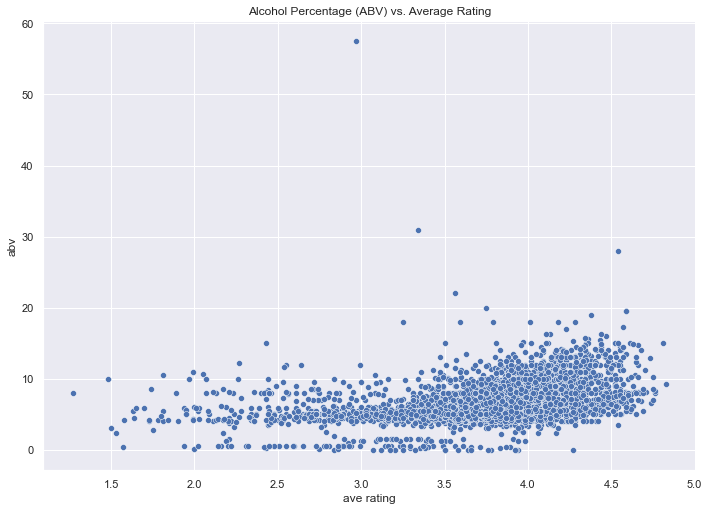

In [8]:
# set figure size
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(data = final, x = 'ave rating', y = 'abv').set(title='Alcohol Percentage (ABV) vs. Average Rating')

We can see that there are a few outliers with a very high alcohol percentage that we probably don't wanna include as it doesn't really make sense to consider those drinks as beers. We'll get rid of the two that have ABV > 25%.
We can also see a cluster of beers at the bottom of the graph with a really low ABV, so it makes sense to differentiate between the two gropus. We made a new column "is alcoholic" to differentiate alcoholic vs non/low alcoholic beers based on 2.5% ABV. This is the threshold according to federal law[^fedLaw]


[^fedLaw]: https://www.ttb.gov/images/pdfs/beer-bam/chapter1.pdf

In [10]:
new_final = final[final['abv'] <= 25] # took 3 beers that were above 25% alcohol
new_final['Is Alcoholic'] = (new_final['abv'] > 2.5) # created new column to distinguish alcoholic beers vs. non/low alcoholic beers (> 2.5 abv)

/var/folders/nb/d_1vl9354vs7vm_nj7q4n7gh0000gn/T/ipykernel_18751/1981287028.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_final['Is Alcoholic'] = (new_final['abv'] > 2.5) # created new column to distinguish alcoholic beers vs. non/low alcoholic beers (> 2.5 abv)


We first grouped beers by style and aggragated to find the mean of the ABV (alcohol by volume). We sorted the means of each style in increasing order and graphed the data as shown above. There is a significant difference in the 2 lowest ABV beers and 2 highest ABV beers. The styles Low Alcohol Beer and Kvass have ABV's of around 0.5 and 1.8 respectively, with the next highest beer having an ABV of around 4.2. Similarly, the top two beers by ABV have about 1 ABV unit higher than the next lowest beer by ABV.

[Text(0.5, 1.0, 'Styles by Alcohol Percentage')]

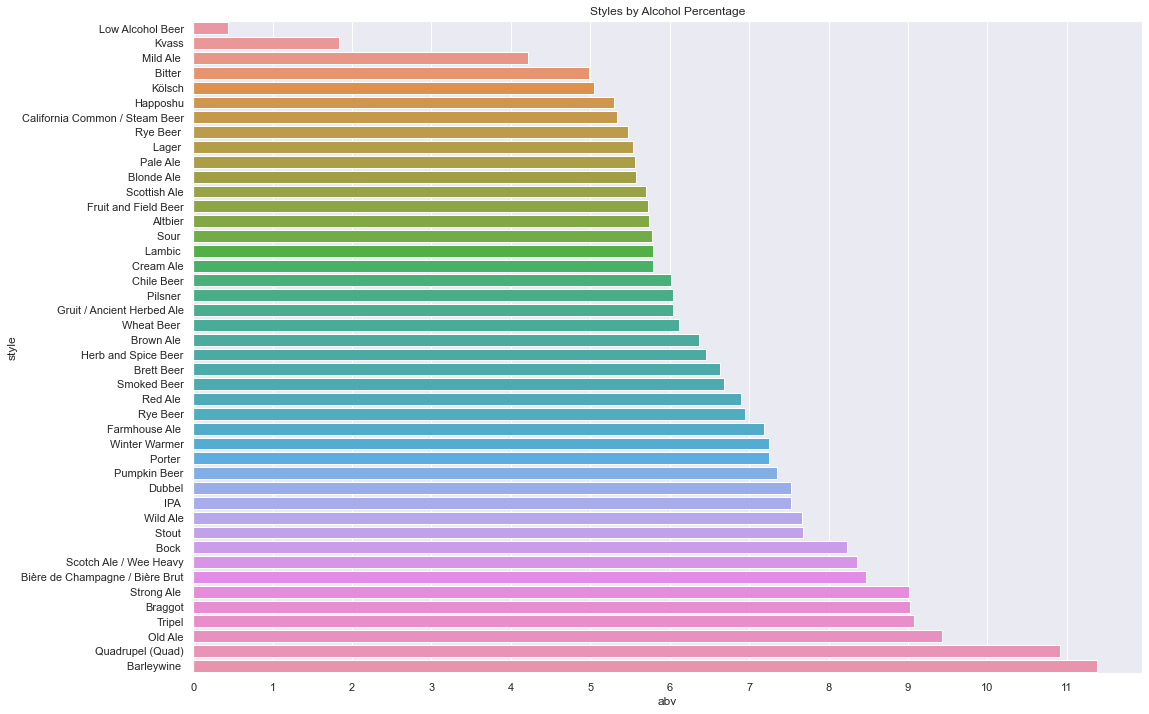

In [11]:
final_grouped = new_final.groupby('style').mean().reset_index().sort_values('abv')
sns.set(rc = {'figure.figsize':(17,12)})
g = sns.barplot(data = final_grouped, x = 'abv', y = 'style')
g.set_xticks(range(12))
g.set(title='Styles by Alcohol Percentage')

[Text(0.5, 1.0, 'Styles by Average Rating')]

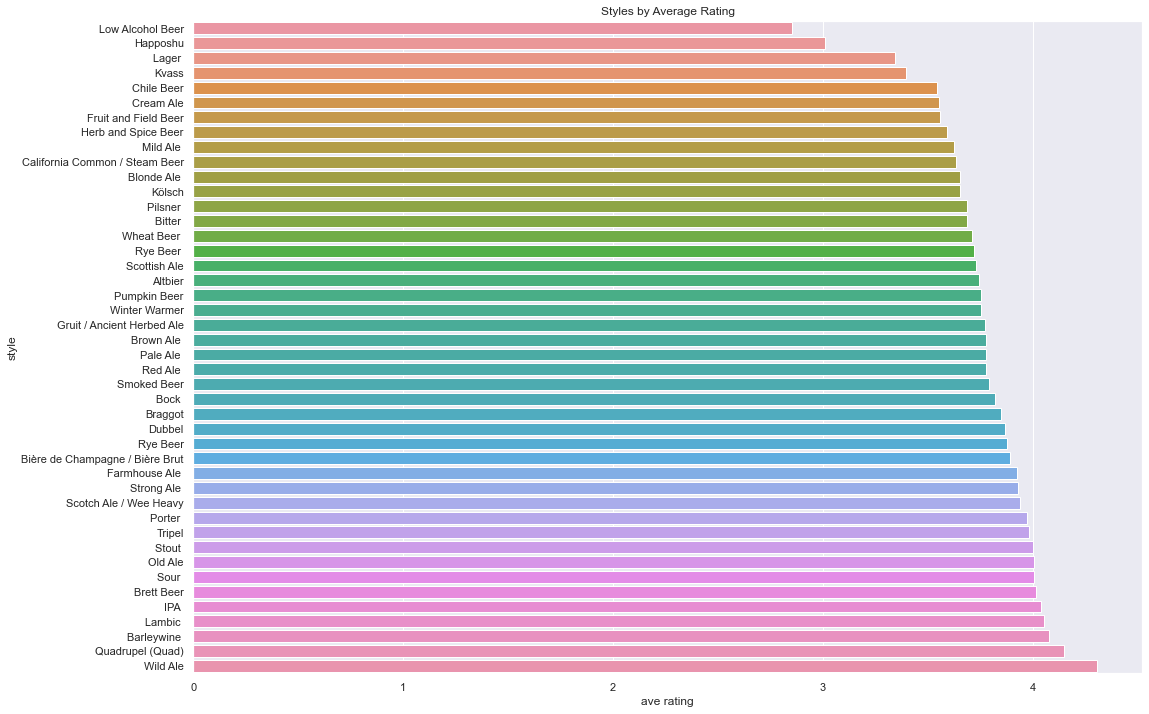

In [12]:
final_grouped2 = new_final.groupby('style').mean().reset_index().sort_values('ave rating')
sns.set(rc = {'figure.figsize':(17,12)})
g = sns.barplot(data = final_grouped2, x = 'ave rating', y = 'style')
g.set_xticks(range(5))
g.set(title='Styles by Average Rating')

We then looked at the average ratings of all of the beer styles. There appears to be no significant difference in average ratings when we look at the vast majority of the styles. It is interesting to note many of the beer styles appear to be in the same order as the previous bar graph. This implies there may be a correlation between ABV and average ratings for the different beer styles. 

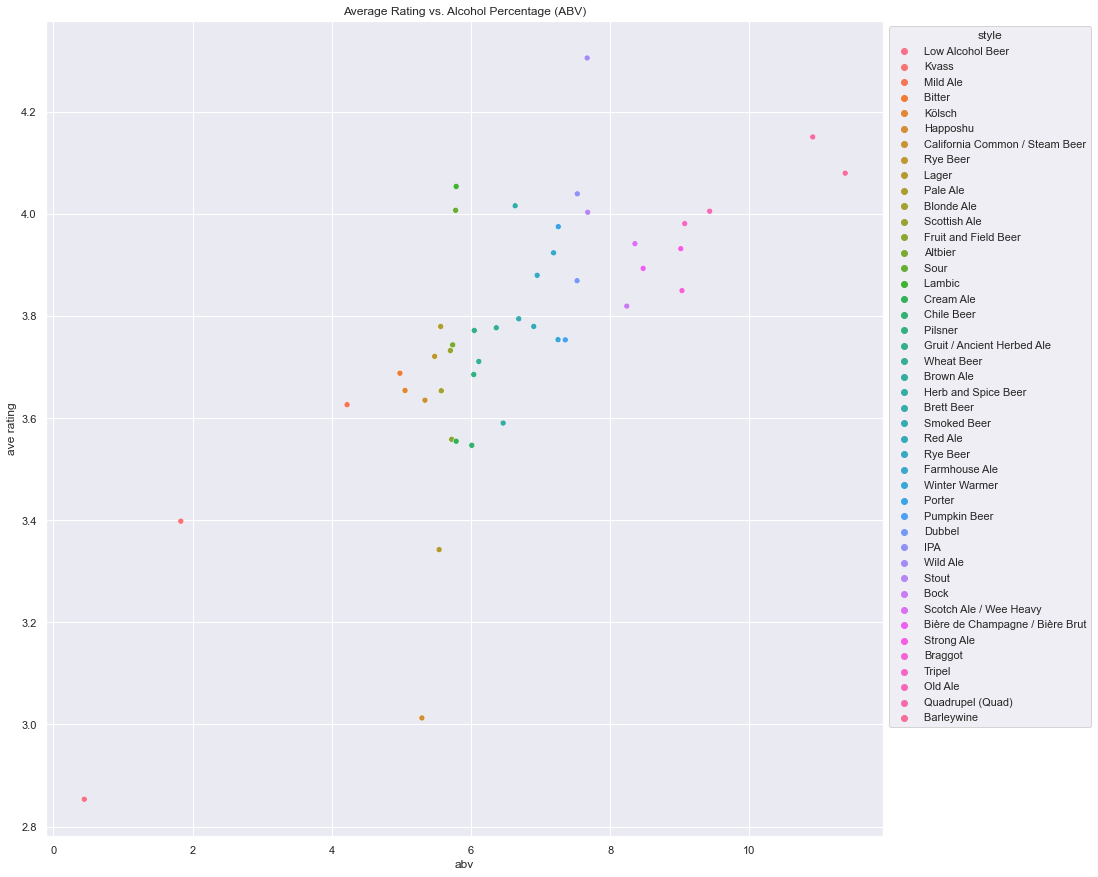

In [13]:
sns.set(rc = {'figure.figsize':(15,15)})
ax = sns.scatterplot(data = final_grouped, x = 'abv', y = 'ave rating', hue = 'style')
ax.set(title='Average Rating vs. Alcohol Percentage (ABV)')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

Here's a scatterplot between ABV and Avg Rating to get a better idea of their relationship after looking after the barplots above.
There's clearly a positive trend between ABV and Avg Rating.

Text(0.5, 1.05, 'Pairwise Relationships Between Style, Alcohol Percentage (ABV), Average Rating, Bitterness')

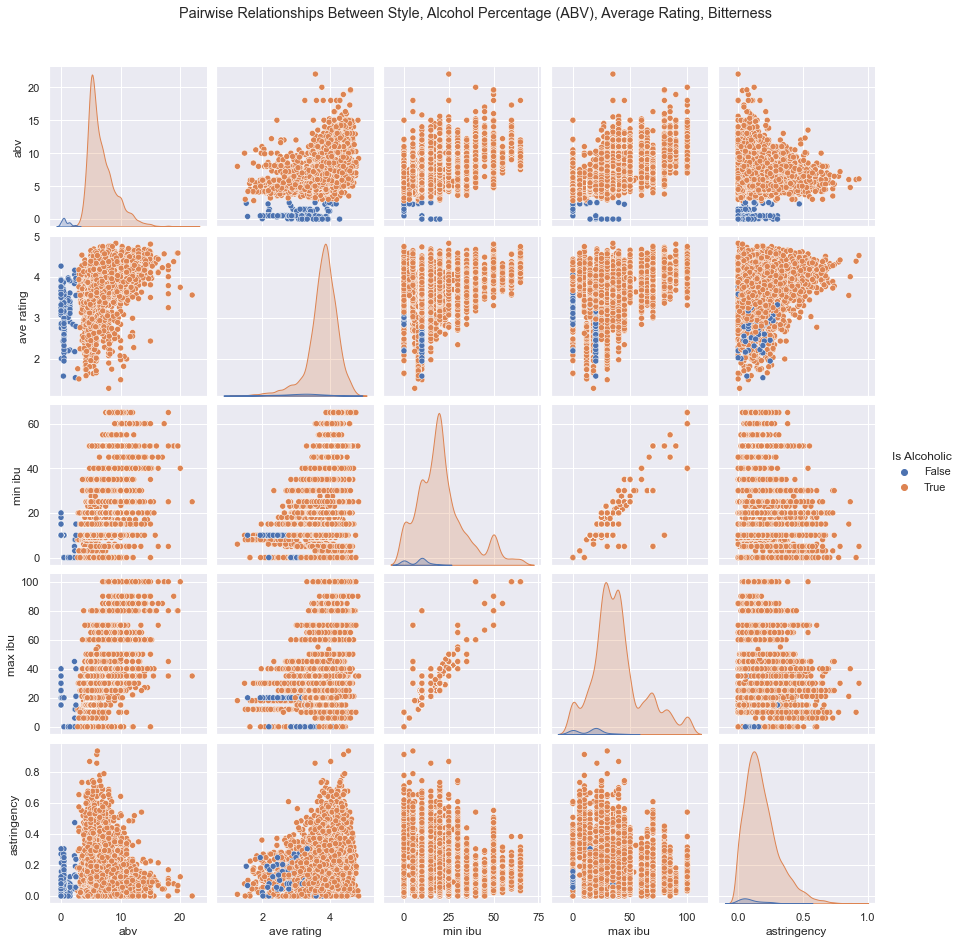

In [14]:
fig1 = sns.pairplot(data = new_final[['style', 'abv', 'ave rating', 'min ibu', 'max ibu', 'astringency', 'Is Alcoholic']], hue = 'Is Alcoholic')
fig1.fig.suptitle('Pairwise Relationships Between Style, Alcohol Percentage (ABV), Average Rating, Bitterness', y=1.05)

The distributions for ABV, Avg rating and astringency seem to have a skewed distribution. Both IBU's have a non-normal distribution. 
If we look at the IBU's against Avg rating, we can see that the data is clustered because IBU is incremented by 5's in our data set.
Astringency and Avg rating appears to have a positive correlation.
The other parts of the graph are irrelevant for our purposes.

Text(0.5, 1.05, 'Pairwise Relationships Between Average Rating, Bitterness, Sweetness, Sourness, Saltiness')

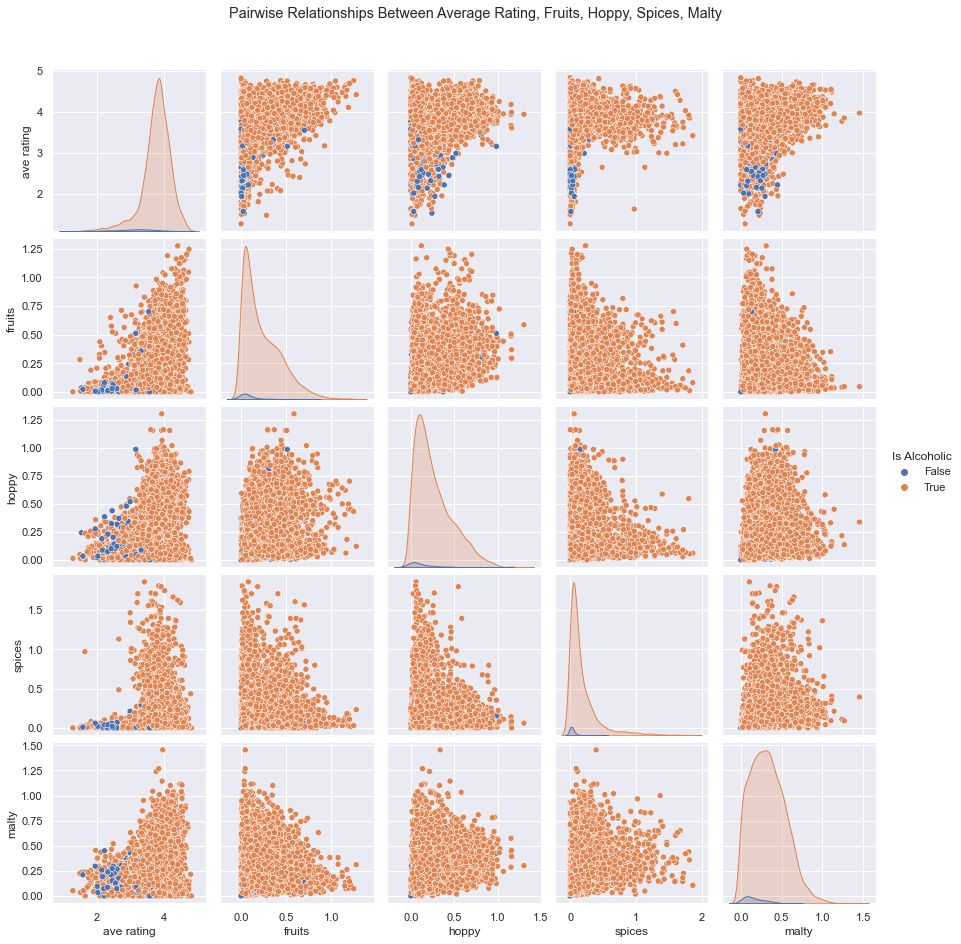

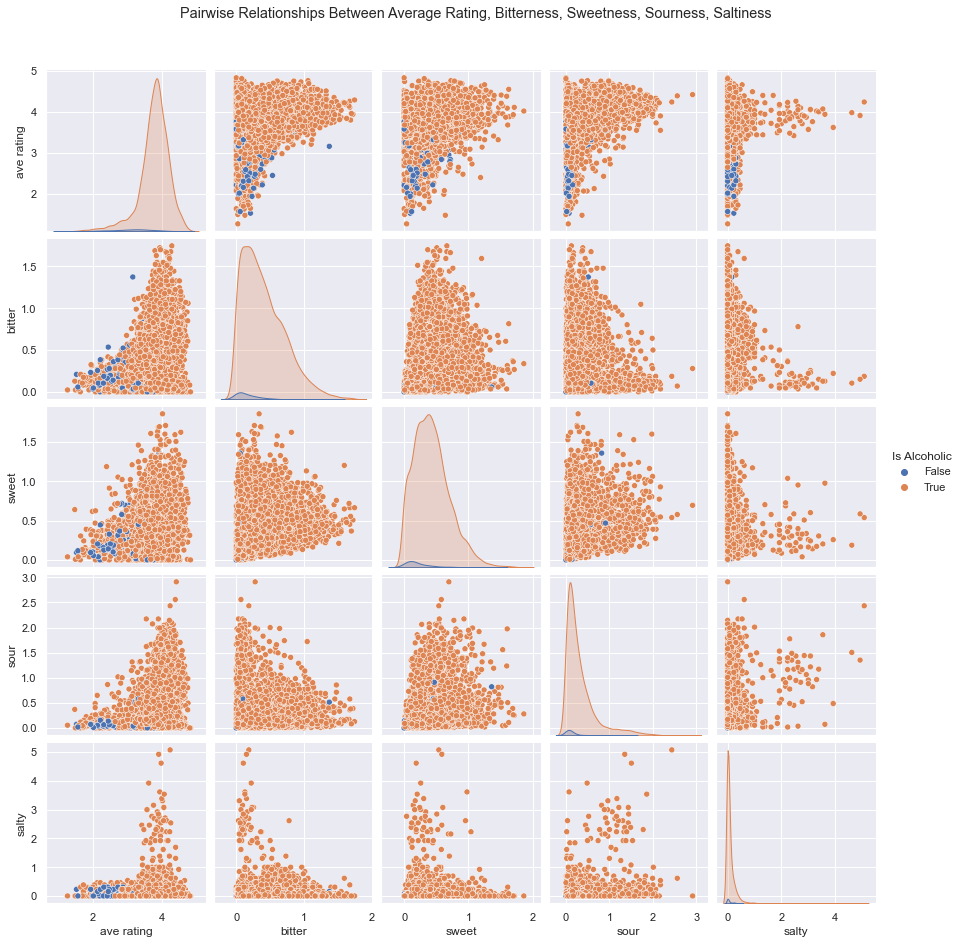

In [15]:
fig2 = sns.pairplot(data = new_final[['ave rating', 'fruits', 'hoppy', 'spices', 'malty', 'Is Alcoholic']], hue = 'Is Alcoholic')
fig2.fig.suptitle('Pairwise Relationships Between Average Rating, Fruits, Hoppy, Spices, Malty', y=1.05)
fig3 = sns.pairplot(data = new_final[['ave rating', 'bitter', 'sweet', 'sour', 'salty', 'Is Alcoholic']], hue = 'Is Alcoholic')
fig3.fig.suptitle('Pairwise Relationships Between Average Rating, Bitterness, Sweetness, Sourness, Saltiness', y=1.05)

Here we explored the distributions of variables representing the taste characteristics. 
Distributions:
- Avg rating looks like a normal distribution
- fruits, hoppy, spices, malty, bitter, sweet, sour, salty all appear to be right skewed. Which makes sense becacuse too much of particular flavor characteristic (for example, if the beer is too sour) can get overwhelming and not pleasant to drink. 

We also looked at the relationship between them and Avg rating. To establish the relationship we look at the Avg rating column. 
For most of the characteristics, we observed: if the characteristic is low, then the average rating is also low. Conversely, the higher the rating gets, the higher the variability of the characteristic for the beer. For example: if the beer has a high rating, the beer can have a low, medium, or high sweetness score; but if the beer has a low rating, the beer is very much more likely to have a low sweetness score. 

In [17]:
new_final = new_final.rename(columns = {'ave rating': 'avg_rating'})
new_final

,style,beer,key,abv,avg_rating,min ibu,max ibu,astringency,body,alcohol,...,sour,salty,fruits,hoppy,spices,malty,mouthfeel,taste,flavor_and_aroma,Is Alcoholic
0,Altbier,ALTerior Motive,297.0,6.3,4.05,25.0,50.0,0.303371,0.628866,0.171875,...,0.414414,0.000000,0.229885,0.520270,0.141414,0.526316,0.396,0.482249,0.713018,True
1,Altbier,Ad Astra Ale,264.0,5.6,3.69,25.0,50.0,0.078652,0.309278,0.078125,...,0.117117,0.076923,0.074713,0.337838,0.060606,0.444976,0.168,0.295858,0.479290,True
2,Altbier,Alt-eration Ale,271.0,5.0,3.81,25.0,50.0,0.235955,0.443299,0.046875,...,0.063063,0.000000,0.057471,0.405405,0.090909,0.531100,0.268,0.340237,0.562130,True
3,Altbier,Altbier,262.0,4.7,4.00,25.0,50.0,0.382022,0.494845,0.140625,...,0.225225,0.076923,0.183908,0.459459,0.121212,0.578947,0.364,0.414201,0.689349,True
4,Altbier,Alternate Dimension,300.0,5.6,3.66,25.0,50.0,0.280899,0.515464,0.187500,...,0.180180,0.000000,0.120690,0.398649,0.262626,0.665072,0.348,0.452663,0.724852,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5346,Winter Warmer,Winter Warmer,673.5,7.2,3.50,35.0,50.0,0.084270,0.520619,0.445312,...,0.139640,0.038462,0.143678,0.172297,0.797980,0.406699,0.346,0.326923,0.634615,True
5347,Winter Warmer,Winter Welcome AleSamuel Smith Old Brewery (Ta...,654.0,6.0,3.69,35.0,50.0,0.191011,0.567010,0.281250,...,0.198198,0.076923,0.172414,0.466216,0.303030,0.454545,0.360,0.405325,0.662722,True
5348,Winter Warmer,Winterbraun,678.0,8.0,3.75,35.0,50.0,0.044944,0.762887,0.546875,...,0.153153,0.153846,0.166667,0.250000,0.272727,0.602871,0.452,0.437870,0.647929,True
5349,Winter Warmer,Winterhook,661.0,6.0,3.62,35.0,50.0,0.123596,0.484536,0.359375,...,0.135135,0.000000,0.086207,0.628378,0.404040,0.464115,0.324,0.393491,0.724852,True


In [18]:
# does alcohol by volume percentage affect a beer's average rating?

import patsy
import statsmodels.api as sm
import scipy.stats as stats

outcome_avg_rating, predictor = patsy.dmatrices('avg_rating ~ abv', new_final)
mod1 = sm.OLS(outcome_avg_rating, predictor)
res1 = mod1.fit()
print(res1.summary())

                            OLS Regression Results                            
Dep. Variable:             avg_rating   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     1209.
Date:                Sun, 04 Dec 2022   Prob (F-statistic):          4.49e-239
Time:                        12:50:27   Log-Likelihood:                -2748.8
No. Observations:                5348   AIC:                             5502.
Df Residuals:                    5346   BIC:                             5515.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.2285      0.016    199.193      0.0

# Ethics & Privacy

*Fill in your ethics & privacy discussion here*

# Conclusion & Discussion

*Fill in your discussion information here*

# Team Contributions

*Specify who in your group worked on which parts of the project.*